In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const


In [10]:
## Two-body dynamics: setting up Leapfrog method

In [11]:
def f(rs, **kwargs):
    """
    Evaluate the second derivative of the position vector in 2D.
    
    Inputs:  array with x-, y- components of the position vector
    Returns: array of x-,y- components of acceleration 
             evaluated at these points
    """
    # position of mass1, mass2    
    x1, y1 = rs[0], rs[1]  
    x2, y2 = rs[2], rs[3] 
    r = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # x, y components of Acceleration 'a'
    ax1 = G*m2*(x2 - x1)/r**3    
    ay1 = G*m2*(y2 - y1)/r**3    
    ax2 = G*m1*(x1 - x2)/r**3    
    ay2 = G*m1*(y1 - y2)/r**3    
    
    return np.array([ax1, ay1, ax2, ay2], float)
    

In [12]:
def leapfrog(t0, tmax, r0, v0, h, f, r_ref, err_tol,  **kwargs):
    """                                                                                                                      
    Calculate a soln x(t) to a 1st-order ODE of the form x'(t)=f(x,t).                                                 
                                                                                                                             
    Uses the leapfrog method.                                                                                
    Inputs: 
    t0 & tmax (Init & final time) 
    r0 (Init pos of m2)
    vx0 & vy0 (Init x- & y- components of velocity)
    h (step size)
    f (function to obtain derivatives: dr, dphi)
    r_ref: expected value for r
    err_tol: amount of allowed deviation from r_ref
    
    Returns: 
    t and x (both arrays of size N=#steps)                                                                          
    """
    
    debug = False
    q = m1/m2
    x1, y1 = r0, 0
    x2, y2 = -q*r0, 0
    vx1, vy1 = 0, v0
    vx2, vy2 = 0,-q*v0
    
    # Initialize arrays for time at each step
    ti = t0
    t = np.array(ti)
        
    # initialize arrays of positions at each step
    r = np.array([x1, y1, x2, y2], float)
    R = np.array([r])
    
    # initialize arrays of velocities at each step
    vinit = np.array([vx1, vy1, vx2, vy2], float)
    v_ = np.array([vinit]) # Initial vx, vy

    # Initialize ti, v_mid
    v_mid = vinit + 0.5*h*f(r) # vinit 
    
    # Append initial v_mid
    v_ = np.append(v_, np.array([v_mid]), axis=0)
    
    # Initialize steps for error check for circular orbit
    r_check = np.sqrt(r[0]**2 + r[1]**2)  # current radius, r
    rel_err = (r_ref - r_check)/r_ref
    print(f"init err: {rel_err}")
    err = np.array([rel_err])
    
    # solve eqns of motion using leapfrog method
    while np.abs(rel_err) < err_tol:
        # break if t = tmax
        if ti > tmax:
            if debug: print(f"Time: {ti} > {tmax}")
            break
        else:
            # calculate r(t), r'(t)
            if debug: print(ti, r, np.abs(r_check - r_ref))
            
            # update t, r, v_mid
            ti += h
            r += h*v_mid
            v_mid += h*f(r) 

            # calculate new rel error
            r_check = np.sqrt(r[0]**2 + r[1]**2)  # current radius, r
            rel_err = (r_ref - r_check)/r_ref

            # save t, r, v_mid
            t = np.append(t, ti)
            R = np.append(R, np.array([r]), axis=0)
            v_ = np.append(v_, np.array([v_mid]), axis=0)
            err = np.append(err, rel_err) # relative error
    
    # components of cartesian coords
    # R: [x1, x2, y1, y2]
    X = R[:,[0,2]]  # x1, x2
    Y = R[:,[1,3]]  # y1, y2
    return t, X, Y, v_ , err


In [13]:
# UNITS: kpc, Msun, Myr
# constants
G = (const.G).to(u.kpc**3 * u.Msun**-1 * u.Myr**-2).value # kpc^3/Msun/Myr

# orbit parameters
m1 = 1e12 # Msun
m2 = 1e12 # Msun
M = m1 + m2

a = 100 # (G*M*T**2/(4*np.pi**2))**(1/3)   # semi-major axis (kpc, Kepler's Law)
ecc =  1e-12 #0.05 #1e-12 # 0.5
p = a*(1 - ecc**2)   # semi-latus rectum (kpc)

# runtime initial conditions
t0, tmax = 0, 5000
h = 1 # 1e-3

# starting position of second galaxy 
r0 = m2*a/M #p   #for circular orbit
    
# starting velocity of the second galaxy
v0 = np.sqrt(G*m2/a)*np.sqrt((m2*(1-ecc**2))/M)

# make sure r is close to analytic value over time
err_tol = 1e-5  # allowable error 


In [14]:
# leapfrog(t0, tmax, r0, v0, h, f, r_ref, err_tol, **kwargs)
t, X, Y, v_, err =  leapfrog(t0, tmax, r0, v0, h, f, r0, err_tol)

init err: 0.0


cumulative error over 5001 Myr: -0.0107631 kpc


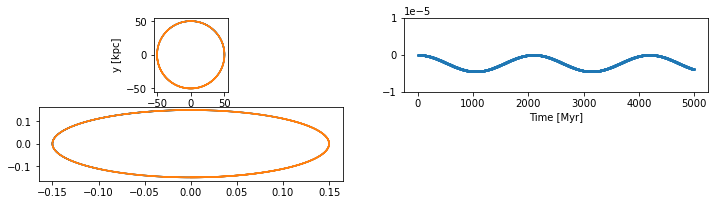

In [20]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(221, aspect='equal')
ax1.plot(X[:,0], Y[:,0], label="m1")
ax1.plot(X[:,1], Y[:,1], label="m2")
ax1.set_xlabel("x [kpc]"), ax1.set_ylabel("y [kpc]")

ax1 = fig.add_subplot(222,aspect='auto')
ax1.scatter(t, err, s=1)
ax1.set_ylim(err_tol*np.array([-1,1]))
ax1.set_xlabel("Time [Myr]"), ax2.set_ylabel("Telative error")
print(f"cumulative error over {t[-1]} Myr: {sum(err):.6} kpc")

ax1 = fig.add_subplot(223,aspect='auto')
ax1.plot(v_[:,0], v_[:,1])
ax1.plot(v_[:,2], v_[:,3])
plt.show()


cumulative error over 5001 Myr: -0.0107631 kpc


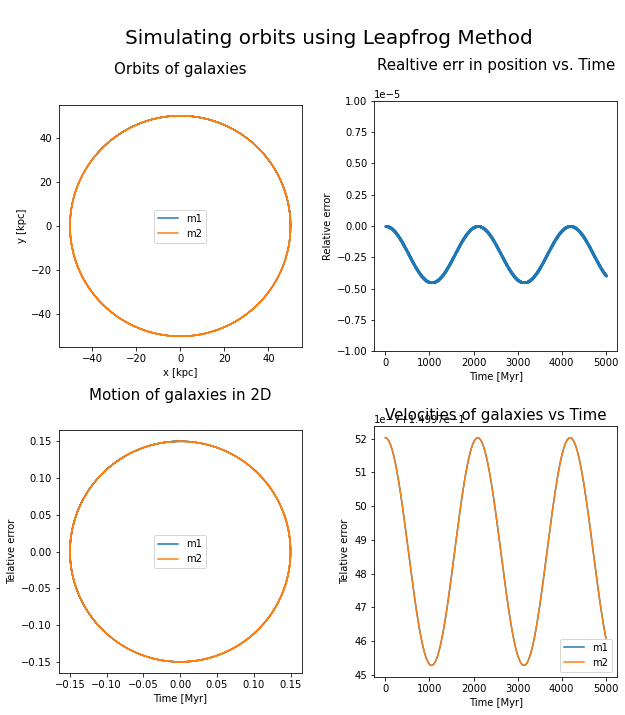

In [52]:
fig = plt.figure(figsize=(10,10))

plt.subplot(221, aspect='equal')
plt.plot(X[:,0], Y[:,0], label="m1")
plt.plot(X[:,1], Y[:,1], label="m2")
plt.xlabel("x [kpc]"), plt.ylabel("y [kpc]")
plt.legend()
plt.title("Orbits of galaxies", fontsize='15', y=1.1)

plt.subplot(222,aspect='auto')
plt.scatter(t, err, s=1)
plt.ylim(err_tol*np.array([-1,1]))
plt.xlabel("Time [Myr]"), plt.ylabel("Relative error")
plt.title("Realtive err in position vs. Time" , fontsize='15', y=1.1)
print(f"cumulative error over {t[-1]} Myr: {sum(err):.6} kpc")

plt.subplot(223,aspect='equal')
plt.plot(v_[:,0], v_[:,1], label="m1")
plt.plot(v_[:,2], v_[:,3], label="m2")
plt.title("Motion of galaxies in 2D", fontsize='15', y=1.1)
plt.legend()
plt.xlabel("Time [Myr]"), plt.ylabel("Telative error")

plt.subplot(224,aspect='auto')
plt.plot(t, np.sqrt(v_[1:,0]**2 + v_[1:,1]**2), label="m1" )
plt.plot(t, np.sqrt(v_[1:,2]**2 + v_[1:,3]**2), label="m2" )
plt.title("Velocities of galaxies vs Time", fontsize='15')
plt.legend()
plt.xlabel("Time [Myr]"), plt.ylabel("Telative error")


fig.suptitle("\nSimulating orbits using Leapfrog Method\n", fontsize = '20')
fig.subplots_adjust(hspace=0.3,wspace=0.3,top=0.85,bottom=0.05)
plt.show()



In [ ]:
v =